## June 2024- Assess Pub Implementation

**Goal**: Assess weight and % of body weight drunk in rats using the pub for the first time

**Context**: The pub came back online around mid-may. This is the first time for any of the behavior room rats using it. The threshold in the pub has been set to 20% of body weights to make sure they are comfortable. This analysis is to assure that we can start lowering the threshold and increasing restriction for the animals.

**Approach**: I will query from the `bdata.SessionAggDate` table. This is a table that Alvaro and I created which joins information from multiple tables (`bdata.Sessions`, `ratinfo.Mass`, `ratinfo.Water`, etc), such that each row is indexed by an animal and date. 

> Written by Jess Breda


## Imports

In [5]:
import datajoint as dj
import session_agg_functions as saf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

dj.conn(host="bdata00.pni.princeton.edu", reset=True)
sns.set_context("talk")


%load_ext autoreload
%autoreload 2

[2024-06-03 22:46:17,936][INFO]: Connecting jbreda@bdata00.pni.princeton.edu:3306
[2024-06-03 22:46:19,054][INFO]: Connected jbreda@bdata00.pni.princeton.edu:3306


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load Data

### 1.1 Fetch From DataJoint

We will start by fetching the `SessionAggDate` table which lives under the `bdata` schema (as opposed to under `ratinfo`).


In [6]:
bdata = dj.create_virtual_module("bdata", "bdata")  # connect to the bdata schema

print(bdata.SessionAggDate.describe())

# Table with rat-date aggregations
session_agg_date_id  : int unsigned auto_increment  
---
ratname              : varchar(30)                  
sessiondate          : date                         
num_sessions         : int                          
n_done_trials        : int                          
hostname             : varchar(30)                  
starttime            : time                         
endtime              : time                         
total_correct=null   : float(2,2)                   
percent_violations=null : float(2,2)                   
right_correct=null   : float(2,2)                   
left_correct=null    : float(2,2)                   
mass=null            : decimal(6,2) unsigned        
tech=null            : varchar(4)                   
percent_target=null  : decimal(6,3)                 
volume=null          : decimal(6,3)                 
num_water=null       : int                          
totalvol=null        : decimal(10,5)                
num_

The columns `num_sessions`, `num_water`, `num_rigwater` are used to document the joining operation. As mentioned above, this table is a unique date, animal. Sometimes, an animal can have multiple sessions in a single day if things crashed, or they are running in multiple rigs. These columns account for that and if you are interested to see the logic of how this aggregation occurs, see [this](https://github.com/Brody-Lab/bl_pipeline_python/blob/main/notebooks/tutorials/Read_agg_date_table.ipynb) set of functions.


The other columns will be explained below when we start manipulating them.

---


Based on my notes, the pub turned on around May 9th, so I will to grab data ~2 weeks prior to that by using a query on the `sessiondate` field. 

In [7]:
date_query = "sessiondate >= '2024-04-25' and sessiondate <= '2024-06-02'"  # create a query for the date range of interest

# fetch the data & format as pandas df
SessAgg = pd.DataFrame((bdata.SessionAggDate() & date_query).fetch(as_dict=True))

### 1.2 Explore the data

In [8]:
SessAgg.head()

,session_agg_date_id,ratname,sessiondate,num_sessions,n_done_trials,hostname,starttime,endtime,total_correct,percent_violations,right_correct,left_correct,mass,tech,percent_target,volume,num_water,totalvol,num_rigwater
0,3437277,C198,2024-04-25,1,497,Rig18,0 days 07:30:01,0 days 11:45:57,0.77,0.15,0.92,0.68,499.00,AB,0.000,0.000,1.0,10.00800,1.0
1,3437278,C199,2024-04-25,1,194,Rig02,0 days 05:25:30,0 days 07:18:52,0.57,0.18,0.52,0.64,534.00,AB,0.000,0.000,1.0,2.23200,1.0
2,3437279,C200,2024-04-25,1,81,Rig02,0 days 00:09:51,0 days 02:33:44,0.00,0.00,0.00,0.00,476.00,AB,0.000,0.000,1.0,0.00000,1.0
3,3437280,C202,2024-04-25,1,311,Rig10,0 days 00:10:41,0 days 02:34:06,0.65,0.38,0.80,0.55,484.00,AB,0.000,0.000,1.0,2.61600,1.0
4,3437281,C203,2024-04-25,1,177,Rig20,0 days 00:10:52,0 days 02:34:17,0.60,0.20,0.69,0.55,534.00,AB,0.000,0.000,1.0,1.20000,1.0


Many of the fields above will look familair since they are from the Sessions table. However, the naming from the water tables can be a bit confusing. Here are some pointers:
* `percent_target` is 0 is the pub isn't run and is located in `ratinfo.Water` it indicates what is the % BW target the pub should restric to
* `totalvol` is the water drunk in the rig and is located in `ratinfo.RigWater`
* `volume` is the water drunk in the pub and is located in `ratinfo.Water`
* `mass` is located in `ratinfo.Mass`
* to compute `volume_target` = `np.round((percent_target / 100) * mass, 2)`


### 1.3 Wrangle the data

There are a few things I want to change about the data before I start plotting.

1. Convert numeric columns `object` (which is like saying they are a string) to `float` or `datetime`
2. Rename columns for clarity when plotting (e.g. `totalvol -> rig_vol`) 
3. Create new columns from data in the table (e.g. `three_percent_target`)
4. Remove mice (i.e. Wynne's animals)
5. Remove phys animals (they have < 20% target in phys pub)

In [9]:
df = SessAgg.copy()  # make a copy of the dataframe

# 1. Correct Types
incorrect_object_cols = ["mass", "percent_target", "volume", "totalvol"]
df[incorrect_object_cols] = df[incorrect_object_cols].astype(float)
df["sessiondate"] = pd.to_datetime(df["sessiondate"])

# 2. Rename Columns
df.rename(columns={"totalvol": "rig_vol", "volume": "pub_vol"}, inplace=True)

# 3. Create New Columns
df["target_vol"] = ((df["percent_target"] / 100) * df["mass"]).round(2)
df["three_percent_target"] = 0.03 * df["mass"]
df["rig_and_pub_vol"] = df["rig_vol"] + df["pub_vol"]
df["percent_body_mass_drunk"] = (df["rig_and_pub_vol"] / df["mass"]) * 100

# 4. Remove Mice (W animals)
df = df[~df["ratname"].str.contains("W")]

# 5. Remove phys animals (percent target > 0 & < 20)
pub_animals = (
    df[(df["percent_target"] > 0) & (df["percent_target"] < 20)]
    .ratname.unique()
    .tolist()
)
df = df[~df["ratname"].isin(pub_animals)]

In [10]:
# df.info()  # uncomment if you want to see types post-conversion
df.head()

,session_agg_date_id,ratname,sessiondate,num_sessions,n_done_trials,hostname,starttime,endtime,total_correct,percent_violations,...,tech,percent_target,pub_vol,num_water,rig_vol,num_rigwater,target_vol,three_percent_target,rig_and_pub_vol,percent_body_mass_drunk
0,3437277,C198,2024-04-25,1,497,Rig18,0 days 07:30:01,0 days 11:45:57,0.77,0.15,...,AB,0.0,0.0,1.0,10.008,1.0,0.0,14.97,10.008,2.005611
1,3437278,C199,2024-04-25,1,194,Rig02,0 days 05:25:30,0 days 07:18:52,0.57,0.18,...,AB,0.0,0.0,1.0,2.232,1.0,0.0,16.02,2.232,0.417978
2,3437279,C200,2024-04-25,1,81,Rig02,0 days 00:09:51,0 days 02:33:44,0.00,0.00,...,AB,0.0,0.0,1.0,0.000,1.0,0.0,14.28,0.000,0.000000
3,3437280,C202,2024-04-25,1,311,Rig10,0 days 00:10:41,0 days 02:34:06,0.65,0.38,...,AB,0.0,0.0,1.0,2.616,1.0,0.0,14.52,2.616,0.540496
4,3437281,C203,2024-04-25,1,177,Rig20,0 days 00:10:52,0 days 02:34:17,0.60,0.20,...,AB,0.0,0.0,1.0,1.200,1.0,0.0,16.02,1.200,0.224719


Great- now things are 95% there. The last thing to do is make some plotting specific columns. 

The first is a column called `days_relative_to_pub`. This will be handy for using as an x-axis and allows for alignment of all animals since the start date was slightly staggered. We will filter to look at roughly 20 days pre and post pub.

The second is a column called `normalized_mass`. This will allow us to compare changes in mass across animals. For this analysis, I am *normalizing mass using the average mass for each animal 7 days prior to the pub start*.

Both of these will be done using a pandas `.groupby()` paired with `.apply()` since these operations need to be applied on a rat-by-rat basis. 

In [11]:
# Define a function to calculate the days relative to the pub turning on
# as determined by the first day pub_vol > 0
def calculate_days_relative_to_pub(group):
    #!note sessiondate must be datetime type to do this
    first_pub_date = group.loc[group["pub_vol"] > 0, "sessiondate"].min()
    group["days_relative_to_pub"] = (group["sessiondate"] - first_pub_date).dt.days
    return group


# Apply the function to each rat
df = df.groupby("ratname").apply(calculate_days_relative_to_pub).reset_index(drop=True)

# Grab a window of 43 days since all animals have data within this range
# this also drops animals with Nan who where on recovery
df = df.query("days_relative_to_pub > -20 and days_relative_to_pub <= 22").copy()

In [12]:
def normalize_pre_pub(group, col_name, previous_days=7):
    pre_pub_average = group.loc[
        group["days_relative_to_pub"].between(-previous_days, -1), col_name
    ].mean()
    group[f"normalized_{col_name}"] = group[col_name] / pre_pub_average
    return group


df = (
    df.groupby("ratname")
    .apply(normalize_pre_pub, col_name="mass")
    .reset_index(drop=True)
)

In [13]:
df[["ratname", "sessiondate", "days_relative_to_pub", "mass", "normalized_mass"]].head()

,ratname,sessiondate,days_relative_to_pub,mass,normalized_mass
0,C198,2024-04-25,-16.0,499.0,0.970008
1,C198,2024-04-26,-15.0,502.0,0.975840
2,C198,2024-04-27,-14.0,508.0,0.987503
3,C198,2024-04-28,-13.0,505.0,0.981672
4,C198,2024-04-29,-12.0,507.0,0.985560


### 1.4 Summarize the Data


In [14]:
n_rats = len(df["ratname"].unique())
n_sessions = len(df)
n_sessions_per_rat = df.groupby("ratname").size().mean()

print(
    f"Number of rats: {n_rats}\nNumber of sessions: {n_sessions}\nAverage number of sessions per rat: {n_sessions_per_rat.round(2)}"
)

Number of rats: 81
Number of sessions: 2668
Average number of sessions per rat: 32.94




## 2. Analysis



### 2.1 Change in Mass with Pub Use

**Goal**: Assess if there have been any significant drops in mass since the start of the pub.


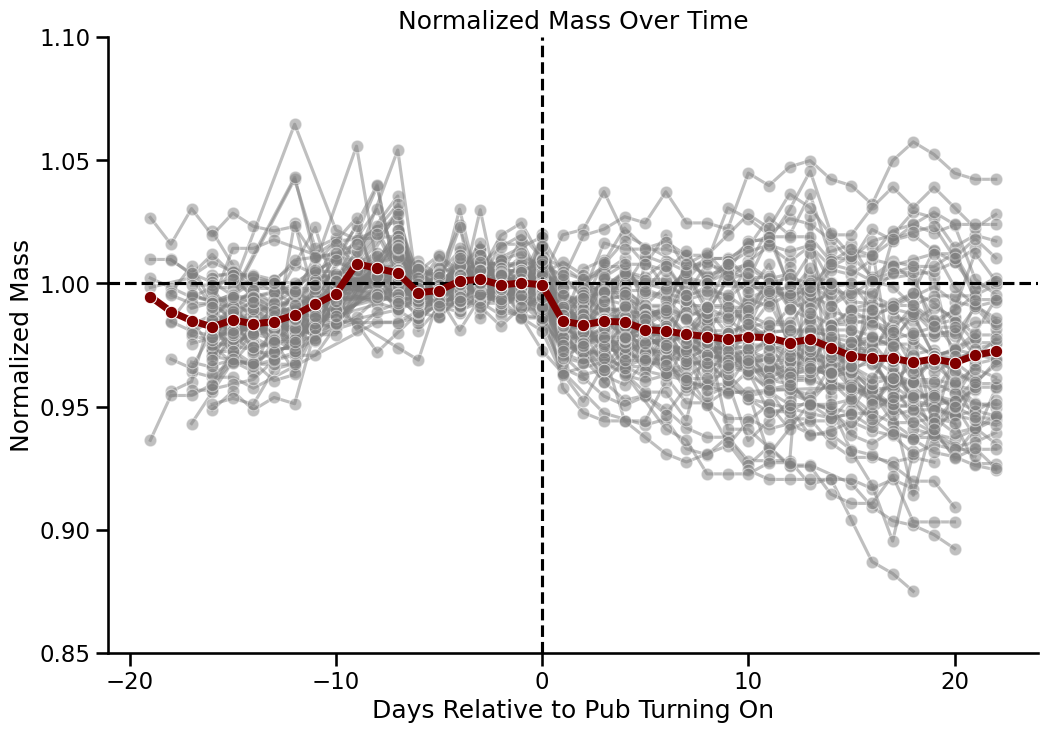

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(
    data=df,
    x="days_relative_to_pub",
    y="normalized_mass",
    color="maroon",
    errorbar=None,
    zorder=100,
    marker="o",
    linewidth=5,
)

palette = sns.color_palette(["gray"], n_rats)  # force all lines to be gray
sns.lineplot(
    data=df,
    x="days_relative_to_pub",
    y="normalized_mass",
    hue="ratname",
    marker="o",
    palette=palette,
    alpha=0.5,
)

ax.axvline(x=0, color="black", linestyle="--")
ax.axhline(y=1, color="black", linestyle="--")


ax.set(
    xlabel="Days Relative to Pub Turning On",
    ylabel="Normalized Mass",
    title="Normalized Mass Over Time",
    ylim=(0.85, 1.10),
)

ax.get_legend().remove()
sns.despine()

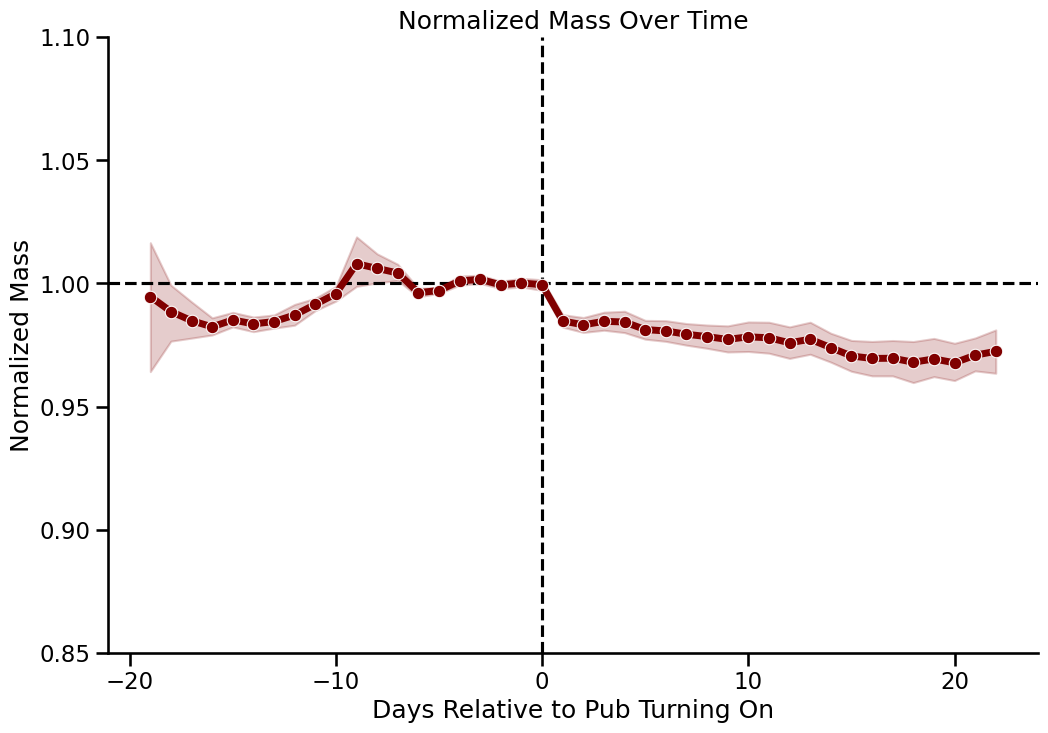

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(
    data=df,
    x="days_relative_to_pub",
    y="normalized_mass",
    color="maroon",
    zorder=100,
    marker="o",
    linewidth=5,
)


ax.axvline(x=0, color="black", linestyle="--")
ax.axhline(y=1, color="black", linestyle="--")


ax.set(
    xlabel="Days Relative to Pub Turning On",
    ylabel="Normalized Mass",
    title="Normalized Mass Over Time",
    ylim=(0.85, 1.10),
)
sns.despine()

#### 2.1.1 Animals with Larger Mass Drops

Given a threshold of 92% of pre-pub mass. Let's plot the animals that have dropped below that. 

In [17]:
norm_mass_threshold = 0.92
ran_names_mass_drop = (
    df.query(f"normalized_mass < {norm_mass_threshold}").ratname.unique().tolist()
)

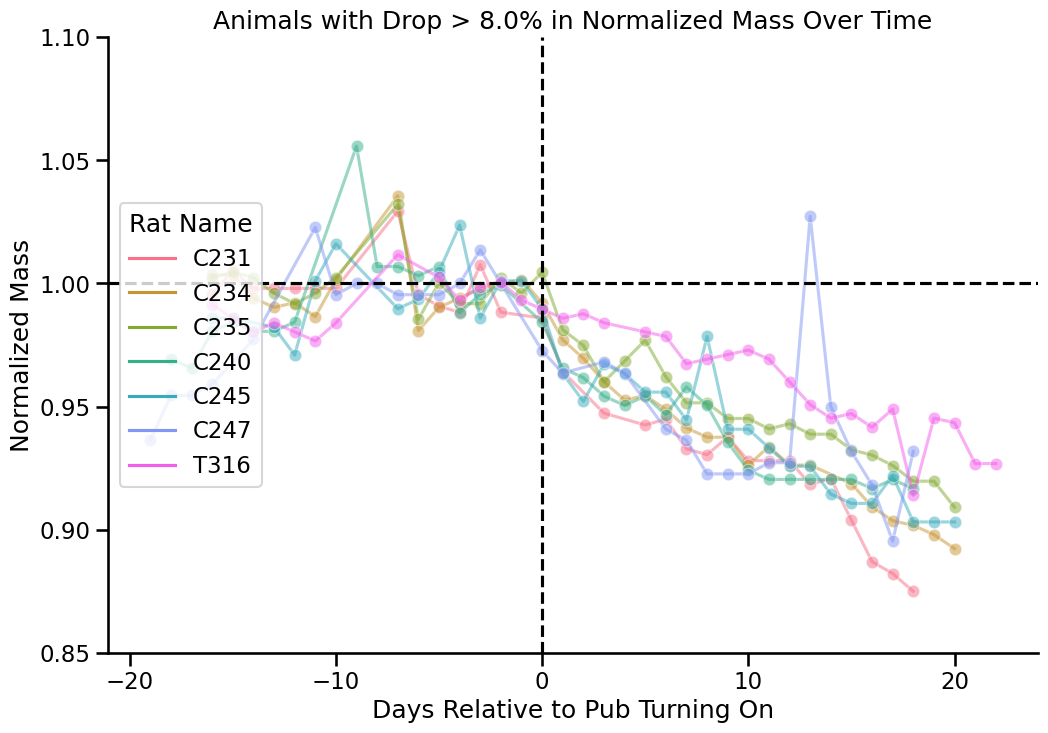

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(
    data=df.query("ratname in @ran_names_mass_drop"),
    x="days_relative_to_pub",
    y="normalized_mass",
    hue="ratname",
    marker="o",
    palette="husl",
    alpha=0.5,
)

ax.axvline(x=0, color="black", linestyle="--")
ax.axhline(y=1, color="black", linestyle="--")


ax.set(
    xlabel="Days Relative to Pub Turning On",
    ylabel="Normalized Mass",
    title=f"Animals with Drop > {round((1-norm_mass_threshold),2) * 100}% in Normalized Mass Over Time",
    ylim=(0.85, 1.10),
)

sns.despine()

ax.legend(loc="center left", title="Rat Name")



### 2.2 % of Body Weight Drunk

**Goal**: Assess if animals are drinking 3% or more of their body weight in a given day (rig and pub combined)

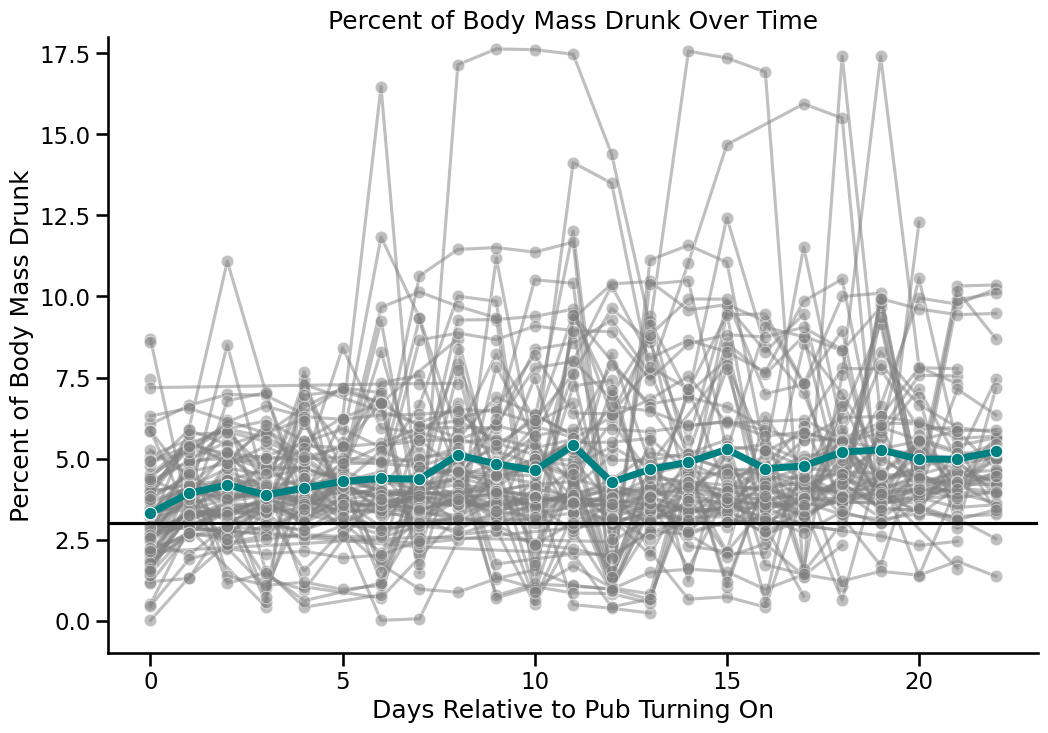

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))

plot_data = df.query("days_relative_to_pub >= 0 and rig_and_pub_vol > 0").copy()
sns.lineplot(
    data=plot_data,
    x="days_relative_to_pub",
    y="percent_body_mass_drunk",
    color="teal",
    errorbar=None,
    zorder=100,
    marker="o",
    linewidth=5,
)

palette = sns.color_palette(["gray"], n_rats)  # force all lines to be gray
sns.lineplot(
    data=plot_data,
    x="days_relative_to_pub",
    y="percent_body_mass_drunk",
    hue="ratname",
    marker="o",
    palette=palette,
    alpha=0.5,
)


ax.axhline(y=3, color="black")


ax.set(
    xlabel="Days Relative to Pub Turning On",
    ylabel="Percent of Body Mass Drunk",
    title="Percent of Body Mass Drunk Over Time",
    ylim=(-1, 18),
)

ax.get_legend().remove()
sns.despine()

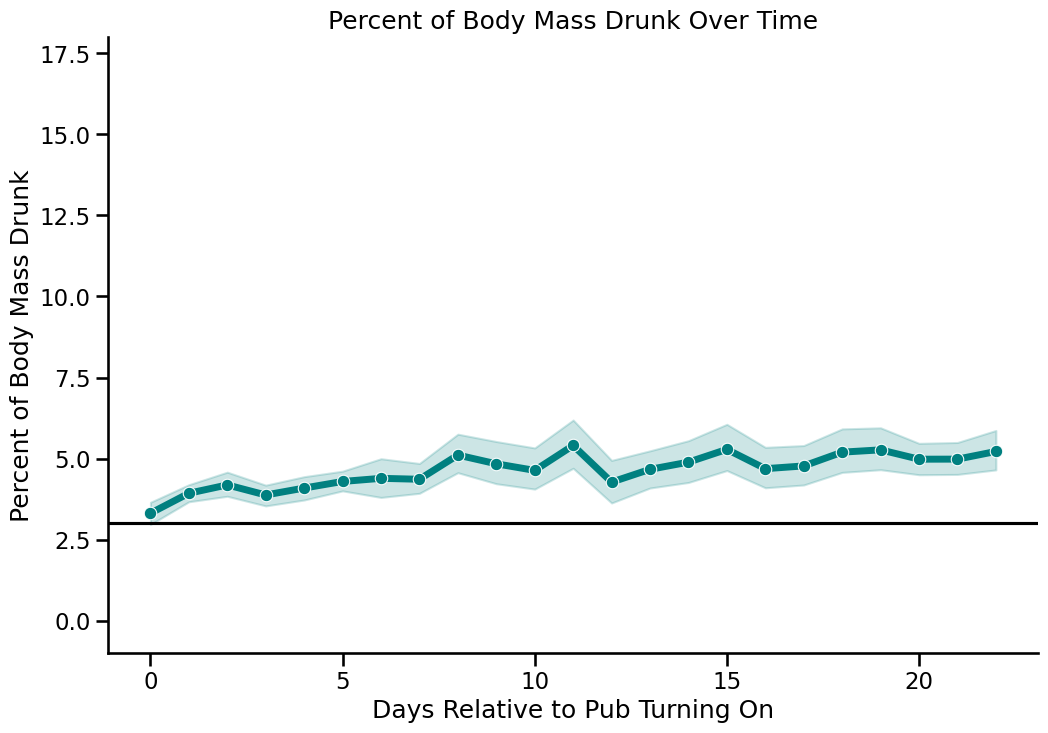

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))

plot_data = df.query("days_relative_to_pub >= 0 and rig_and_pub_vol > 0").copy()
sns.lineplot(
    data=plot_data,
    x="days_relative_to_pub",
    y="percent_body_mass_drunk",
    color="teal",
    zorder=100,
    marker="o",
    linewidth=5,
)


ax.axhline(y=3, color="black")


ax.set(
    xlabel="Days Relative to Pub Turning On",
    ylabel="Percent of Body Mass Drunk",
    title="Percent of Body Mass Drunk Over Time",
    ylim=(-1, 18),
)

sns.despine()

#### 2.2.1 Animals with Low Volume Drunk

Given a threshold of 3% of BW Drunk, let's plot the animals that have dropped below that. 


In [21]:
drink_threshold = 3
rat_names_pub_threshold = (
    df.query("days_relative_to_pub > 0")  # only days post pub on
    .groupby("ratname")
    .percent_body_mass_drunk.mean()  # average percent body mass drunk
    .reset_index()
    .query("percent_body_mass_drunk < @drink_threshold")  # animals < than 3% avg
    .ratname.unique()
    .tolist()
)

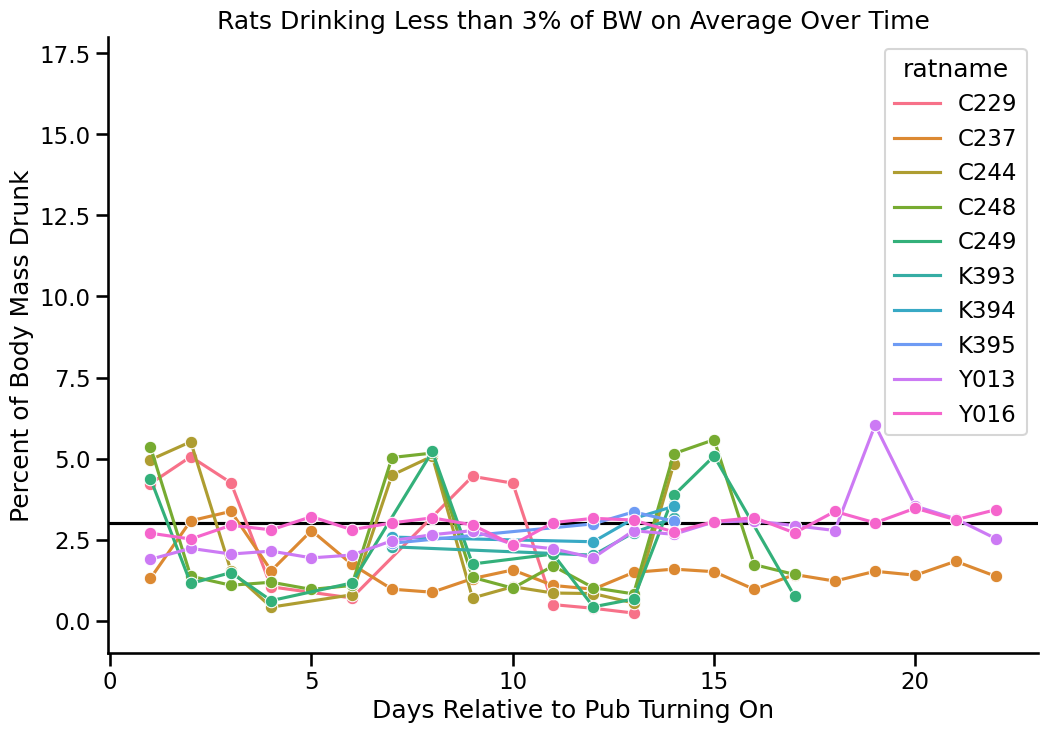

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(
    data=plot_data.query(
        "ratname in @rat_names_pub_threshold and days_relative_to_pub > 0"
    ),
    x="days_relative_to_pub",
    y="percent_body_mass_drunk",
    zorder=100,
    hue="ratname",
    palette="husl",
    marker="o",
)


ax.axhline(y=3, color="black")


ax.set(
    xlabel="Days Relative to Pub Turning On",
    ylabel="Percent of Body Mass Drunk",
    title="Rats Drinking Less than 3% of BW on Average Over Time",
    ylim=(-1, 18),
)

sns.despine()